# `Planet`: a convenient way to access planetary data

Written by [Doriann Blain](mailto:doriann.blain@gmail.com).

With petitRADTRANS, you can use the `Planet` object to easily access planetary parameters from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html). To use it, you first need to import it:

In [1]:
from petitRADTRANS.planet import Planet

## Getting `Planet` data

The `Planet` object automatically downloads data from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/), provided that you give the **exact** planet name as used by the NASA archive (case and space sensitive).

In [2]:
planet = Planet.get('HD 209458 b')  # an internet connection is required the first time a Planet is obtained

file '/home/dblain/petitRADTRANS/input_data/planet_data/planet_HD_209458_b.vot' not found, downloading...


<div class="alert alert-warning">
    
Be careful to enter the **exact** name of your planet, including case and spaces.
</div>

<div class="alert alert-info">

- All values are given in CGS units.
- The value of each attribute is taken from **the field with the smallest errorbars**, so different parameter may come from different sources. This is similar, but not identical, to the [NASA Exoplanet Archive Composite Planet Data Table](https://exoplanetarchive.ipac.caltech.edu/docs/pscp_about.html).
- The next time you need to use a `Planet` with the same name, no download will be necessary.
- The information are stored within your ["input_data"](https://petitradtrans.readthedocs.io/en/latest/content/installation.html#pre-installation-download-the-opacity-data) folder, in the planet_data directory, as an HDF5 file.
</div>

## Basic `Planet` usage
Now you can use your `Planet`'s attributes to get key parameters such as the mass, radius, semi-major axis, system distance, etc. All of the `Planet` units are in CGS, so the attributes of your `Planet` can be directly plugged in pRT.

Here is an example to display the radius of the planet with its upper and lower uncertainties:

In [3]:
# Display the planet radius and its uncertainties
print(
    f"{planet.name}'s radius: {planet.radius * 1e-5:.0f} "
    f"+{planet.radius_error_upper * 1e-5:.0f} / {planet.radius_error_lower * 1e-5:.0f} km"
)

HD 209458 b's radius: 98659 +1215 / -1215 km


The list of the `Planet` attributes can be accessed from using the object's `__dict__`:

In [4]:
for key in planet.__dict__:
    print(f"{key}")

name
mass
mass_error_upper
mass_error_lower
radius
radius_error_upper
radius_error_lower
orbit_semi_major_axis
orbit_semi_major_axis_error_upper
orbit_semi_major_axis_error_lower
orbital_eccentricity
orbital_eccentricity_error_upper
orbital_eccentricity_error_lower
orbital_inclination
orbital_inclination_error_upper
orbital_inclination_error_lower
orbital_period
orbital_period_error_upper
orbital_period_error_lower
argument_of_periastron
argument_of_periastron_error_upper
argument_of_periastron_error_lower
epoch_of_periastron
epoch_of_periastron_error_upper
epoch_of_periastron_error_lower
ra
dec
x
y
z
reference_pressure
density
density_error_upper
density_error_lower
reference_gravity
reference_gravity_error_upper
reference_gravity_error_lower
equilibrium_temperature
equilibrium_temperature_error_upper
equilibrium_temperature_error_lower
insolation_flux
insolation_flux_error_upper
insolation_flux_error_lower
bond_albedo
bond_albedo_error_upper
bond_albedo_error_lower
transit_depth
tran

<div class="alert alert-warning">

A description of these attributes is available on the [NASA Exoplanet Archive website](https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html) (see Table label). **Remember that for `Planet`, the units has been converted to CGS.**
</div>

## Other useful function

The `Planet` object provides functions to estimate useful parameters.

<div class="alert alert-warning">

All the functions described below, starting with `calculate_`, must be used with a `Planet` instance. They all have an alternative function, starting with `compute_`, which can be used without a `Planet` instance, but require more arguments. For example, `calculate_equilibrium_temperature` has an alternative function `compute_equilibrium_temperature`, which can be called with `Planet.compute_equilibrium_temperature(...)`.
</div>

Let's make some useful imports first.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

### Useful functions for observations from Earth

These functions make use of the `astropy.coordinates` [module](https://docs.astropy.org/en/stable/coordinates/index.html).

Let's set an observing time in Modified Julian Day ([MJD](https://en.wikipedia.org/wiki/Julian_day)):

In [6]:
observing_time = 60068.37965278  # (MJD)

#### Astropy coordinates

It is possible to retrieve the planet's astropy coordinates of both a target and an observation site with the `get_astropy_coordinates` function:

In [7]:
observer_location, target_coordinates = planet.get_astropy_coordinates(
    ra=planet.ra,
    dec=planet.dec,
    site_name='paranal observatory',
    # latitude=None,  # alternatively, any coordinate can be used
    # longitude=None,
    # height=None
)

print(f"Observer location: {observer_location}")
print(f"Target astropy's SkyCoord: {target_coordinates}")

Observer location: (1946404.34103884, -5467644.29079852, -2642728.20144425) m
Target astropy's SkyCoord: <SkyCoord (ICRS): (ra, dec) in deg
    (330.7950219, 18.8842419)>


<div class="alert alert-info">

The `SkyCoord` `astropy` object is described [here](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html). The variable `observer_location` is an `astropy` `EarthLocation` [object](https://docs.astropy.org/en/stable/api/astropy.coordinates.EarthLocation.html). Both objects can be used in `astropy` functions where they are required in argument. For more details, please refer to the `astropy` [documentation](https://docs.astropy.org/en/stable/index_user_docs.html).
</div>

The following functions make use, internally, of the above coordinates:

#### [Airmass](https://en.wikipedia.org/wiki/Air_mass_(astronomy))

In [8]:
airmass = planet.calculate_airmass(
    time=observing_time,
    site_name='paranal observatory',
    # latitude=None,  # alternatively, any coordinate can be used
    # longitude=None,
    # height=None,
    time_format='mjd'
)

print(f" Airmass looking at {planet.name} ({observing_time:.2f} MJD): {airmass:.2f}")

 Airmass looking at HD 209458 b (60068.38 MJD): 2.02


#### [Barycentric velocity](https://docs.astropy.org/en/stable/coordinates/velocities.html#radial-velocity-corrections)

In [9]:
v_bary = planet.calculate_barycentric_velocities(
    time=observing_time,
    site_name='paranal observatory',
    # latitude=None,  # alternatively, any coordinate can be used
    # longitude=None,
    # height=None,
    time_format='mjd'
)

print(f" Barycentric velocity looking at {planet.name} ({observing_time:.2f} MJD): {v_bary * 1e-5:.2f} km.s-1")

 Barycentric velocity looking at HD 209458 b (60068.38 MJD): 23.18 km.s-1


### Other useful functions


#### Equilibrium temperature
If not provided by the NASA Exoplanet Archive, the equilibrium temperature of an orbiting `Planet` can be calculated with `Planet.calculate_equilibrium_temperature()`.

In [10]:
equilibrium_temperature, equilibrium_temperature_error_upper, equilibrium_temperature_error_lower = planet.calculate_equilibrium_temperature()

print(f"T_eq (calculated): {equilibrium_temperature:.2f} (+ {equilibrium_temperature_error_upper:.2f} - {np.abs(equilibrium_temperature_error_lower):.2f}) K")
print(f"T_eq (from archive): {planet.equilibrium_temperature:.2f} (+ {planet.equilibrium_temperature_error_upper:.2f} - {np.abs(planet.equilibrium_temperature_error_lower):.2f}) K")

T_eq (calculated): 1458.07 (+ 9.69 - 9.91) K
T_eq (from archive): 1459.00 (+ 12.00 - 12.00) K


<div class="alert alert-info">
    
The errorbars are calculated using the `petitRADTRANS.utils.calculate_uncertainties()` function, using the uncertainties on the star effective temperature, the star radius, and the orbit semi-major axis.
</div>

#### Full transit duration

The total transit duration ($T_{14}$) is given by the attribute `transit_duration`, and represents the time the planet eclipses the star, including ingress and egress. The full transit duration ($T_{23}$), which represents the time that the planet's disk is totally within the star's disk (without ingress and egress).

In [11]:
full_transit_duration = planet.calculate_full_transit_duration()

print(f"Full transit duration: {full_transit_duration / 3600:.2f} h")
print(f"Total transit duration: {planet.transit_duration / 3600:.2f} h")

Full transit duration: 2.24 h
Total transit duration: 3.07 h


#### Impact parameter

In astronomy, the impact parameter of a transit ($b$) is defined as the minimum distance between a planet's disk center and its star's disk center as seen in projection by the observer, in units of the star's radius.

In [12]:
impact_parameter = planet.calculate_impact_parameter()

print(f"Impact parameter: {impact_parameter:.2f} star radius")

Impact parameter: 0.47 star radius


#### Mid transit time

The mid transit time ($T_0$) is the time (or date) at which a transitting planet is halfway through its transit. 

The function calculates the date of the closest transit after the observation day (JD), using the `transit_midpoint_time` argument as reference.

In [13]:
mid_transit_time, mid_transit_time_error_upper, mid_transit_time_error_lower, n_orbits = planet.calculate_mid_transit_time(
    observation_day=observing_time + 2400000.5,  # conversion to JD
    day2second=False  # if True, return the result in seconds since the start of the transit's day
)

print(f"Mid transit time of {planet.name} (closest after {observing_time:.2f} MJD): "
      f"{mid_transit_time - 2400000.5:.5f} +/- {np.mean(np.abs((mid_transit_time_error_upper, mid_transit_time_error_lower))):.5f} MJD "
      f"(from {n_orbits:.0f} orbits since the reference transit at {planet.transit_midpoint_time / 3600 / 24 - 2400000.5:.2f} MJD)"
)

Mid transit time of HD 209458 b (closest after 60068.38 MJD): 60069.49068 +/- 0.00072 MJD (from 2386 orbits since the reference transit at 51659.44 MJD)


#### Orbital phases and orbital longitudes
The orbital phase ($\phi$) represents the position of a transiting planet (with low eccentricty) along its orbit relative to the observer. The orbital phase is 0 when the planet is in front of the star relative to the observer (mid primary transit), while it is 0.5 when the planet is behind the star (mid secondary transit).

The orbital longitude is equivalent, but instead of being unitless like the orbital phase, it can be expressed in degree or radian.

The `Planet` function to calculate the orbital phase loops the value back to 0 when the orbital phase reaches -1 or +1.

Text(0, 0.5, 'Orbital phase')

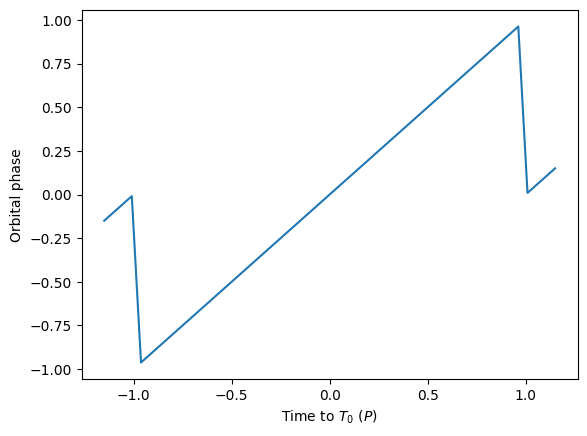

In [14]:
times_to_mid_transit = np.linspace(-planet.orbital_period * 1.15, planet.orbital_period * 1.15)  # (s)

orbital_phases = planet.calculate_orbital_phases(
    phase_start=0.0,  # start at mid-transit since the times are given relative to mid-transit
    times=times_to_mid_transit
)

plt.plot(times_to_mid_transit / planet.orbital_period, orbital_phases)
plt.xlabel(r'Time to $T_0$ ($P$)')
plt.ylabel('Orbital phase')

The equivalent in orbital longitudes can be obtained as follows:

Text(0, 0.5, 'Orbital longitude (deg)')

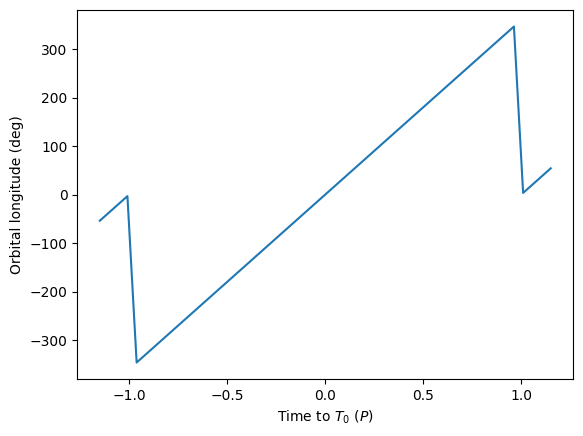

In [15]:
orbital_longitudes = planet.calculate_orbital_longitudes(
    longitude_start=0.0,  # start at mid-transit since the times are given relative to mid-transit
    times=times_to_mid_transit,
    rad2deg=True  # convert radians into degrees
)

plt.plot(times_to_mid_transit / planet.orbital_period, orbital_longitudes)
plt.xlabel(r'Time to $T_0$ ($P$)')
plt.ylabel('Orbital longitude (deg)')

#### Radial velocity, $K_p$, orbital velocity

The radial velocities relative to an observer at given orbital longitudes, assuming an eccentricity close to 0 and a planet mass negligible compared to the star mass, can be obtained as follows:

Text(0, 0.5, 'Radial velocity (km.s-1)')

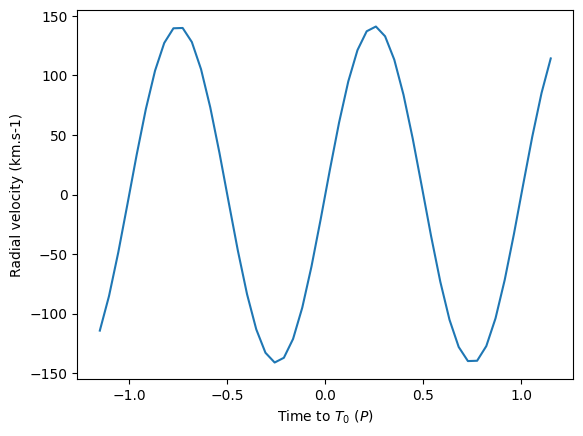

In [16]:
radial_velocities = planet.calculate_radial_velocity(orbital_longitudes)  # orbital longitudes in degree

plt.plot(times_to_mid_transit / planet.orbital_period, radial_velocities * 1e-5)
plt.xlabel(r'Time to $T_0$ ($P$)')
plt.ylabel('Radial velocity (km.s-1)')

Useful intermediates can also be calculated. One of them is the radial velocity semi-amplitude ($K_p$), which can be obtained as follows:

In [17]:
radial_velocity_semi_amplitude = planet.calculate_radial_velocity_semi_amplitude()

print(f"K_p = {radial_velocity_semi_amplitude * 1e-5:.2f} km.s-1")

K_p = 141.14 km.s-1


The orbital velocity, again assuming a circular orbit, is obtained via:

In [18]:
orbital_velocity = planet.calculate_orbital_velocity()

print(f"Orbital velocity = {orbital_velocity * 1e-5:.2f} km.s-1")

Orbital velocity = 141.34 km.s-1


### Mass, radius, reference gravity
If not provided by the NASA Exoplanet Archive, the mass, radius, and reference gravity (aka "surface gravity") can be calculated using:
- `Planet.mass2reference_gravity`
- `Planet.reference_gravity2radius`
- `Planet.reference_gravity2mass`

For example, the planet's mass can be obtained from its reference gravity:

In [19]:
from petitRADTRANS import physical_constants as cst

mass, mass_error_upper, mass_error_lower = Planet.reference_gravity2mass(
    reference_gravity=planet.reference_gravity,
    radius=planet.radius,
    reference_gravity_error_upper=planet.reference_gravity_error_upper,
    reference_gravity_error_lower=planet.reference_gravity_error_lower,
    radius_error_upper=planet.radius_error_upper,
    radius_error_lower=planet.radius_error_lower
)

print(f"mass: {mass / cst.m_jup:.2f} (+ {mass_error_upper / cst.m_jup:.2f} - {np.abs(mass_error_lower) / cst.m_jup:.2f}) M_Jup")

mass: 0.68 (+ 0.03 - 0.03) M_Jup


## Loading and saving
By default, the `Planet` data are stored in a HDF5 file within your "input_data" folder, in the planet_data directory, and the data come from the NASA Exoplanet Archive.
However, if you want to customize the data of your `Planet` (or create one from scratch), you can use the `Planet.load()` and `Planet.save()` functions. For example:

In [20]:
import copy
import os

my_planet = copy.deepcopy(planet)
my_planet.radius = 1.5 * cst.r_earth
my_planet.name='My Planet'

file_name = os.path.join('.', 'generated_files', 'my_planet.h5')

my_planet.save(filename=file_name)  # this will save the Planet under my_planet.h5, in the working directory
my_planet.load(name='my_planet', filename=file_name)

print(f"My Planet radius: {my_planet.radius / cst.r_earth:.2f} R_earth")

My Planet radius: 1.50 R_earth


## Plotting the planet's mass and radius in context to other exoplanets

It can be nice to visualize how the planet compares to other exoplanets in term of mass and radius. The function `plot_planet_context` can be used for that purpose.

<div class="alert alert-info">
    
The latest data from the confirmed planets of the NASA Expoplanet Archive will be used. By default, only the planets for which the mass and radius are known within 15% are plotted in the scatter plot. Not all the confirmed planets have a known mass and radius, hence the total count in the histogram plots can be less than the total number of confirmed exoplanets.
</div>

Fetching for Nasa Exoplanet Archive Planetary Systems Composite Parameters Table...
Selecting planets...
 Selection statistics:
  - Planets in table: 5747
  - Planets in mass histogram: 5724
  - Planets in radius histogram: 5726
  - Planets in scatter plot: 630
Drawing plot...


/mnt/c/Users/doria/OneDrive/Documents/programs/Python/petitRADTRANS/petitRADTRANS/plotlib/plotlib.py:1572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


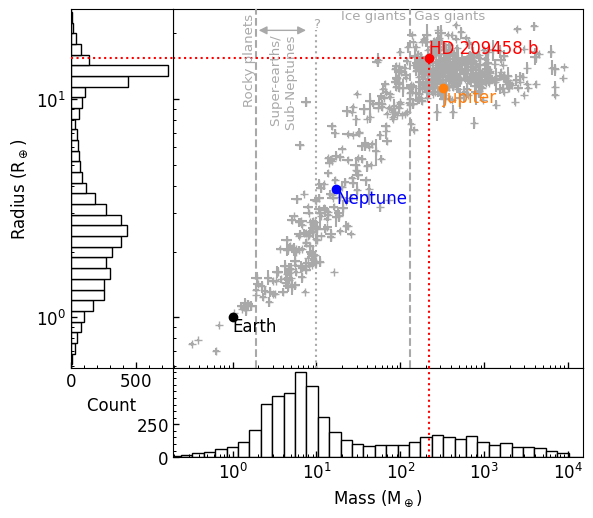

In [21]:
from petitRADTRANS.plotlib import plot_planet_context

plot_planet_context(planet.name)